# Profiling

Profiling should be considered a mandatory prerequisite to code optimization; without solid data on how your program runs it is likely you will misidentify the bottlenecks and waste valuable time and effort on the wrong sections of code. Additionally, profiling provides you with information as to what the bottleneck is. Given how easy it is in Python, this is not something to be skipped.

## Timing your code
The first port of call is almost always timing how long your code takes to run. Python provides the `time` module for you, which allows you to take timepoints before and after your code, take the difference, and see how long the code took. We show an example of this below.

In [2]:
import time

def fib(n):
    """Compute the nth Fibonacci number."""
    if n <= 2:
        return 1
    return fib(n - 1) + fib(n - 2)

start_time = time.time()
result = fib(35)
end_time = time.time()
print(f"fib(30) = {result}, computed in {end_time - start_time:.3f} seconds")

fib(30) = 9227465, computed in 0.962 seconds


On our computer, calling `fib(30)` gave us the result 832040, in 0.088 seconds.

**QUESTION: How long does the `fib` function take with the inputs n = 20, 35, and 40? Write the answers down. How about other numbers? Is there a pattern?**

<details>
<summary>My answers</summary>
On my machine:

- `fib(20)` ran in 0.01 seconds
- `fib(30)` ran in 0.088 seconds
- `fib(35)` ran in 0.905 seconds
- `fib(40)` ran in 9.861 seconds

</details>

**QUESTION: Without editing the code provided, how long does `fib(10)` take?**

However, an operating system is complex and it is likely that there are many things going on at the same time as you executing the code, things which could affect how your code runs. A single sample can often give you the right ballpark, but running the code repeatedly allows the random effects of your OS environment to be averaged out. Of course, *non-random* effects may not be averaged out.

If you're using IPython or a Jupyter Notebook, you can use a helpful little bit of magic. The `%timeit` command, written before a line of Python code, will run that line multiple times and report back the mean and standard deviation of the time. It will also adjust the relevant time unit on the fly, so you don't have to adjust the requested precision manually. For example:

In [3]:
%timeit fib(32)

215 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


If you want to time an entire code block, you use the `%%timeit` (note two % symbols) at the start of a code block.

In [4]:
%%timeit
fib(32)
fib(33)

567 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


For numerical work, of course, you probably aren't using a notebook to run your code. The equivalent module and function for a Python script is the (default provided) `timeit` module and function. To use that, we call:

In [5]:
import timeit
print(timeit.timeit('fib(32)', globals = globals(), number=10))

2.355248615999699


Lets explain that code a little bit. The `timeit` function from the `timeit` module runs a function call, provided as the first argument here as a string which it evaluates. You can specify the number of repetitions with the `number=` argument; here we've specified 10 because the default is 1_000_000 and we know this function call will take more than a few microseconds. The `globals = globals()` argument and value pass the global environment to the function, in case any of the code relies on something there.

The function returns the *total* time in float seconds that the entire set of repetitions took. You can easily divide by the number of repetitions to get the mean.

The documentation for the `timeit` module can be found [here](https://docs.python.org/3/library/timeit.html)

**QUESTION: What happens if you delete the `globals = globals()` argument?**

You can also run the `timeit` function from the command line interface (CLI) if you wish to test short snippets of code.

**NOTE** The `timeit` module turns off Garbage Collection during the timing, to avoid the performance impact of that process. This makes timing repetitions more independent, but if you want to test with real-world conditions or GC is an important part of the function being tested, it can be turned back on (see documentation).

## More informative profiling
Timing your code is a good starting point which can provide information as to whether it is even worth it to optimize your code, and as you proceed it can tell you whether you have successfully achieved speedup of your code. However, it generally doesn't offer enough information to identify *why* the code is slower than desired. To do that, we have to turn to other packages, which provide more information.

### cProfile
The first of these is `cProfile`. This module (provided with Python) also provides a time estimate, but it is important to note that the time estimate will likely be larger. `cProfile` is a deterministic profiler which systematically records *every* function call. Consequently, using it adds overhead to every function call. As it is written in `C`, (hence `c` `profile`), the overhead is usually reasonable, but you should be aware of it.

As with `timeit`, to use `cProfile` we provide a string representation of the function we want to profile.

In [6]:
import cProfile
cProfile.run('fib(30)', sort = "cumulative")

         1664082 function calls (4 primitive calls) in 0.242 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.242    0.242 {built-in method builtins.exec}
        1    0.000    0.000    0.242    0.242 <string>:1(<module>)
1664079/1    0.242    0.000    0.242    0.242 1582476348.py:3(fib)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In our example, we order by "cumulative" to sort the output table by the `cumtime` - i.e. the cumulative time. 

`cProfile` provides an estimate of the total number of function calls and the overall time taken. The number of primitive function calls is the number of calls that were not recursive - i.e. they were not generated by other function calls. We see that there were 4 primitive function calls out of a total of 1,664,082 total. If we look at the table, we see the first column is `ncalls`, which shows that 4 different functions had 1 primitive calls, and that `fib` generated 1,664,079 recursive calls. In `tottime` we see that essentially all the time was spent in the `fib()` function, although there were so many calls that the `percall` time was still 0. 

We can also output the results of `cProfile` to file for use with the `pStats` module, which can allow us to save our output and also do more complex manipulations of it.

In [7]:
import pstats
cProfile.run('fib(30)', 'fib_stats') # save the stats to fib_stats
p = pstats.Stats('fib_stats') # read the fib_stats file
p.sort_stats('cumulative').print_stats("fib") # print only the stats for the fib function

Wed Jun 25 13:22:37 2025    fib_stats

         1664082 function calls (4 primitive calls) in 0.244 seconds

   Ordered by: cumulative time
   List reduced from 4 to 1 due to restriction <'fib'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
1664079/1    0.244    0.000    0.244    0.244 /tmp/ipykernel_533/1582476348.py:3(fib)




In addition, you can use `cProfile` through the notebook interface using `%prun` for a single line of code, and `%%prun` for a code block.

In [8]:
%prun fib(30)

         1664082 function calls (4 primitive calls) in 0.242 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
1664079/1    0.242    0.000    0.242    0.242 1582476348.py:3(fib)
        1    0.000    0.000    0.242    0.242 {built-in method builtins.exec}
        1    0.000    0.000    0.242    0.242 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [9]:
%%prun
f30 = fib(30)
f31 = fib(31)
f32 = fib(32)
assert f32 == f30 + f31

         8713236 function calls (6 primitive calls) in 1.242 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
8713233/3    1.242    0.000    1.242    0.414 1582476348.py:3(fib)
        1    0.000    0.000    1.242    1.242 {built-in method builtins.exec}
        1    0.000    0.000    1.242    1.242 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

### line_profiler
`cprofile` is very useful, and it can tell you which functions are being called most, and how much time they're taking. If you've split your code into smaller functions (usually best practice) then it can really narrow down where the majority of your computation is happening. However, it still can't identify the lines of code where time is being taken - if your function is 5 lines of code all you know is that it is *somewhere* in that 5 lines of code.

Enter `line_profiler`, an externally developed module which can profile your code down to the line. This is incredibly useful.

To use the package, we have to use the decorator it provides `@profile` on the functions we want to profile. We can then run it from the CLI (for a script), remembering to set the `LINE_PROFILE` environmental variable to 1 before running the code, or else it won't run.

**Use the command `LINE_PROFILE=1 python examples/primes-line-profiler.py` in your CLI**

**QUESTION: What line of the `find_primes()` function takes the most time?**

You can also use the line_profiler in a notebook, using a magic command. `%lprun` for a single command. We tell the module what function we want to profile using the `-f` flag, and call the function. Running the magic command will then run line_profiler on the code. An example of this is below.

Note that `line_profiler` needs to be loaded using `%load_ext line_profiler` for these commands to be available.

In [19]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [20]:
%lprun -f fib fib(30)

Timer unit: 1e-09 s

Total time: 0.377648 s
File: /tmp/ipykernel_533/1582476348.py
Function: fib at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def fib(n):
     4                                               """Compute the nth Fibonacci number."""
     5   1664079  181986604.0    109.4     48.2      if n <= 2:
     6    832040   72753401.0     87.4     19.3          return 1
     7    832039  122908103.0    147.7     32.5      return fib(n - 1) + fib(n - 2)

## Profiling Exercises

We're going to be running profiling on some code which generates the Julia set for a region of the complex plane, where $f(z) = z^2 + c$, written in `julia_set.py`. For those unfamiliar, the Julia Set of this function is the set of values where, under repeated iteration of the function, a small perturbation in value leads to drastic changes in the sequence of iterated values. 

We plot the Julia Set below.

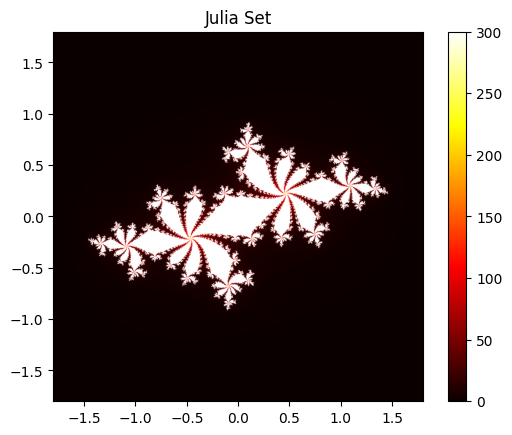

In [25]:
from julia_set import visualise_julia_set
visualise_julia_set(desired_width = 1000, max_iterations = 300)

The white regions of space are those values where even after 300 iterations of $f(z)$, the sequence of values has not "escaped" outside this region of the complex plane - rather, the sequence simply jumps around unpredictably. The black areas are those areas where applying $f(z)$ leads to immediate escape, and therefore 0 iterations. As you can see, it leads to a pretty (and fractal!) pattern.

**Q1. Have a look at the code. Run it in the CLI. How long does it take to run on your machine? Feel free to edit the code. Write the total time down**

<details>
<summary>CLI code</summary>

In your CLI, run `python julia_set.py`
</details>

<details>
<summary>How do I time the code?</summary>
That's up to you. You could edit the code to add in timing steps, as was done earlier. You could also import the code and run it in a notebook cell.

<details>
<summary>Give me code to import the code and time it</summary>

```
from julia_set import run_julia_set
%timeit run_julia_set(desired_width = 1000, max_iterations = 300)
```
</details>

</details>

**Q2: Where do you think any bottlenecks might be? Write down your hypothesis.**

**Q3: What functions do you think are called most in `run_julia_set(1000, 300)`? Think about it, then try and profile it. Is it what you expect?**

<details>
<summary>I need a hint</summary>

Use `cProfile` on `run_julia_set()` to get the time spent in each function.

<details>
<summary>I need a bigger hint</summary>

Either import the code and use the `%prun` magic to profile `run_julia_set(1000, 300)`, or do so in a Python REPL.

<details>
<summary>I want the code</summary>
For a notebook

```{python}
from julia_set import run_julia_set
%prun run_julia_set(desired_width = 1000, max_iterations = 300)
```

For a REPL, replace the second line with `cProfile("run_julia_set(desired_width = 1000, max_iterations = 300)")`
</details>
</details>
</details>



**Q4: What part of `calc_z_serial_python()` do you *expect* to take the longest? What actually takes the longest?**

<details>
<summary>I need a hint</summary>

Use `line_profiler`
<details>
<summary>I need a bigger hint</summary>

Edit the code with the `@profile` decorator and profile from the CLI.
<details>
<summary>Give me the code</summary>

Add `from line_profiler import profile` and `@profile`decorator above `calc_z_serial_python`

Then, in the CLI, run
`LINE_PROFILE=1 python julia_set.py`

</details>
</details>
</details>

**Q6: The same as Q5 for `calc_complex_numbers()`. What part(s) do you expect, and what in actuality, takes the longest?**

<details>
<summary>I need a hint</summary>

Use `line_profiler`
<details>
<summary>I need a bigger hint</summary>

Edit the code with the `@profile` decorator and profile from the CLI.
<details>
<summary>Give me the code</summary>

Add `from line_profiler import profile` and `@profile`decorator above `calc_complex_numbers`

Then, in the CLI, run
`LINE_PROFILE=1 python julia_set.py`

</details>
</details>
</details>

**Q6: With all the information you have gained, was your hypothesis about the bottleneck right?**

**Q7: With all the information you now have, what areas of the code do you think you should focus on optimizing if you wanted to make the calculations faster?**